# Efficiently representing radio astronomy data in qbits

## Creating Antenna Fields

In [72]:
import numpy as np

In [80]:
class Antenna:
    #complex values + conjuguate
    def __init__(self, x, y):
        self.x = float(x)
        self.y = float(y)
        
    def __str__(self):
        return str(self.x) + ' + ' 'i' + str(self.y)
        
    def __repr__(self):
        return str(self.x) + ' + ' 'i' + str(self.y)

In [81]:
antennas = []
n = 10
for i in range(0, n):
    antennas.append(Antenna(np.random.rand(), np.random.rand()))
    
print(antennas)

[0.4442244743428767 + i0.5963021662564955, 0.8696723866087108 + i0.03331905129731583, 0.002268543522779054 + i0.04810386758602503, 0.16825535857465412 + i0.6101183107067113, 0.5871773513159367 + i0.6466223719557734, 0.03237334336541253 + i0.9793791117604268, 0.3786484978953435 + i0.3461360703966949, 0.890896609450728 + i0.8165423037548988, 0.650134430634558 + i0.1259110438085873, 0.8171562181162236 + i0.23762505360587083]


In [83]:
matrix_form = np.zeros((n, n, 4)) 
XX = 0
XY = 0
YX = 0
YY = 0

for i in range(0, len(antennas)):
    for j in range(0, i):
        matrix_form[i][j][XX] = antennas[i].x * antennas[j].x
        matrix_form[j][i][XX] = antennas[i].x * antennas[j].x
        matrix_form[i][j][XY] = antennas[i].x * antennas[j].y
        matrix_form[j][i][XY] = antennas[i].x * antennas[j].y
        matrix_form[i][j][YX] = antennas[i].y * antennas[j].x
        matrix_form[j][i][YX] = antennas[i].y * antennas[j].x
        matrix_form[i][j][YY] = antennas[i].y * antennas[j].y
        matrix_form[j][i][YY] = antennas[i].y * antennas[j].y
     
print(matrix_form)

[[[0.         0.         0.         0.        ]
  [0.01986822 0.         0.         0.        ]
  [0.02868444 0.         0.         0.        ]
  [0.36381487 0.         0.         0.        ]
  [0.38558232 0.         0.         0.        ]
  [0.58400589 0.         0.         0.        ]
  [0.20640169 0.         0.         0.        ]
  [0.48690594 0.         0.         0.        ]
  [0.07508103 0.         0.         0.        ]
  [0.14169633 0.         0.         0.        ]]

 [[0.01986822 0.         0.         0.        ]
  [0.         0.         0.         0.        ]
  [0.00160278 0.         0.         0.        ]
  [0.02032856 0.         0.         0.        ]
  [0.02154484 0.         0.         0.        ]
  [0.03263198 0.         0.         0.        ]
  [0.01153293 0.         0.         0.        ]
  [0.02720641 0.         0.         0.        ]
  [0.00419524 0.         0.         0.        ]
  [0.00791744 0.         0.         0.        ]]

 [[0.02868444 0.         0.         

## Naive representations

In [76]:
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np

### Circuit family #1

In [77]:
def encoding(inp):
    
    qc = QuantumCircuit(1, 1) 
    qc.reset(0)
    
    if inp=='1':
        qc.x(0)
    
    qc.draw('mpl')
        
    return qc 

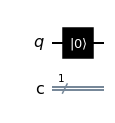

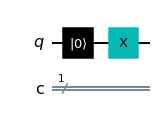

In [78]:
#testing
for inp in ['0', '1']:
    qc = encoding(inp)
    display(qc.draw(output='mpl'))
    print('\n')

In [71]:
for i in range(0, len(matrix_form[0])):
    for j in range(0, len(matrix_form[1])):
        for k in range(0, len(matrix_form[2])):
            for l in range(0, len(matrix_form[i][j][k])): #pb
                print(float_to_bin(matrix_form[i][j][k][l]))

TypeError: object of type 'numpy.float64' has no len()

## Utils

In [79]:
#float to binary / binary to float
import struct

def float_to_bin(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

def bin_to_float(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]